# **Лабораторна робота №1**
## з дисципліни **"Методи оптимізації та дослідження операцій"**

##### *За темою:* **"Метод Ньютона"**

<div style="display: flex;">

<div style="flex: 1;">
    <i>Виконавці роботи:</i><br>
    бригада №21
    <br><br>
    <i><b>
    Баштовий Іван<br>
    Гавлицький Іван<br>
    Харитонов Олександр<br>
    Ходаковський Артур
    </i></b>
</div>

<div style="flex: 1;">
<i>Прийняли:</i>
<br><br><br><br>
<i><b>Яковлєва А. П.</i></b><br>
<i><b>Спекторський І. Я.</i></b>
</div>

</div>

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Задання символьних змінних для багатовимірних функцій
def create_symbols(n):
    return sp.symbols(f'x0:{n}')

# Генерація градієнта
def grad(func, symbols, values):
    grad_f = [sp.diff(func, sym) for sym in symbols]
    grad_f = [g.subs(dict(zip(symbols, values))) for g in grad_f]
    return np.array(grad_f, dtype=float)

# Генерація матриці Гессе
def hessian(func, symbols, values):
    hess_f = [[sp.diff(sp.diff(func, sym1), sym2) for sym1 in symbols] for sym2 in symbols]
    hess_f = [[h.subs(dict(zip(symbols, values))) for h in row] for row in hess_f]
    return np.array(hess_f, dtype=float)

# Перевірка умови зупинки
def condition(func, symbols, dot0, dot1, eps):
    return np.linalg.norm(dot1-dot0) < eps

# Генерація нових напрямків пошуку
def hk(func, symbols, dot):
    return -np.linalg.inv(hessian(func, symbols, dot)).dot(grad(func, symbols, dot))





In [2]:
# Класичний метод Ньютона для багатовимірних функцій
def reg_newton(func, symbols, dott, eps=1e-05):
    array_of_dots = [dott]

    params = {
        'dots': [array_of_dots[0]],
        'f': [func.subs(dict(zip(symbols, array_of_dots[0])))],
        'hk': [],
        'iterations': 0
    }

    while True:
        params['hk'].append(hk(func, symbols, array_of_dots[-1]))

        array_of_dots.append(array_of_dots[-1] + hk(func, symbols, array_of_dots[-1]))

        params['dots'].append(array_of_dots[-1])
        params['f'].append(func.subs(dict(zip(symbols, array_of_dots[-1]))))

        params['iterations'] += 1

        # Виведення інформації на кожній ітерації
        print(f"Classic Newton - Iteration {params['iterations']}: point = {array_of_dots[-1]}, f(point) = {params['f'][-1]}")
        
        if condition(func, symbols, array_of_dots[-1], array_of_dots[-2], eps):
            params['hk'].append(np.nan)
            break

    return params


In [3]:
# Умова зупинки для регулювання Ньютона
def cond(func, symbols, xk, xkk, alph, eps):
    return (func.subs(dict(zip(symbols, xkk))) - func.subs(dict(zip(symbols, xk)))) <= eps * alph * np.dot(grad(func, symbols, xk), hk(func, symbols, xk))

# Регульований метод Ньютона для багатовимірних функцій
def reg_new(func, symbols, dott, eps=1e-05, alpha=1, e=1/2):
    array_of_dots = [dott]
    array_of_alpha = [alpha]

    params = {
        'alpha': [array_of_alpha[0]],
        'dots': [array_of_dots[0]],
        'f': [func.subs(dict(zip(symbols, array_of_dots[0])))],
        'hk': [],
        'iterations': 0
    }

    while True:
        armijo_loop = True
        hk_current = hk(func, symbols, array_of_dots[-1])
        params['hk'].append(hk_current)
        
        if armijo_loop:
            array_of_dots.append(array_of_dots[-1] + alpha * hk_current)

            if cond(func, symbols, array_of_dots[-2], array_of_dots[-1], alpha, e):
                alpha = alpha
                array_of_alpha.append(alpha)
                armijo_loop = False
            else:
                alpha = alpha * 0.5

        params['alpha'].append(array_of_alpha[-1])
        params['dots'].append(array_of_dots[-1])
        params['f'].append(func.subs(dict(zip(symbols, array_of_dots[-1]))))
        
        params['iterations'] += 1

        # Виведення інформації на кожній ітерації
        print(f"Regulated Newton - Iteration {params['iterations']}: point = {array_of_dots[-1]}, f(point) = {params['f'][-1]}")

        if condition(func, symbols, array_of_dots[-1], array_of_dots[-2], eps):
            params['hk'].append(np.nan)
            break

    return params



In [4]:
# Функція для побудови графіка контурів для багатовимірних функцій
def plot_contour(func, symbols, fixed_vals, x_idx, y_idx, x_range=(-10, 10), y_range=(-10, 10), levels=60):
    # fixed_vals: список фіксованих значень для всіх змінних, крім x_idx і y_idx
    x_vals = np.linspace(x_range[0], x_range[1], 100)
    y_vals = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(x_vals, y_vals)

    subs_dict = {symbols[i]: fixed_vals[i] for i in range(len(symbols)) if i != x_idx and i != y_idx}
    f = sp.lambdify((symbols[x_idx], symbols[y_idx]), func.subs(subs_dict), 'numpy')
    Z = f(X, Y)

    plt.figure(figsize=(8, 6))
    CS = plt.contour(X, Y, Z, levels=levels)
    plt.clabel(CS, inline=True, fontsize=10)
    plt.title(f'Contour plot of f(x{x_idx}, x{y_idx}) with other variables fixed')
    plt.xlabel(f'x{x_idx}')
    plt.ylabel(f'x{y_idx}')
    plt.grid(True)
    plt.show()

# Візуалізація результатів
def plot_results(result, func, symbols, method_name):
    fig, ax = plt.subplots(1, 2, figsize=(14, 7))

    # Графік збіжності функції
    ax[0].plot(result['f'])
    ax[0].set_title(f'Convergence plot ({method_name})')
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('f(x)')

    # Графіки збіжності для кожної координати
    dots = np.array(result['dots'])
    for i, sym in enumerate(symbols):
        ax[1].plot(dots[:, i], label=str(sym))
    ax[1].set_title(f'Convergence of each coordinate ({method_name})')
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Value')
    ax[1].legend()

    plt.show()

    # Графік контурів для функцій з двома і більше змінними
    if len(symbols) >= 2:
        fixed_vals = result['dots'][-1]
        plot_contour(func, symbols, fixed_vals, 0, 1)

In [5]:
# Приклад використання для обох методів
def example_usage(f, n, starting_point):
    symbols = create_symbols(n)
    func = f(*symbols[:n])  # Змінити функцію за потреби

    # Виконання класичного методу Ньютона
    result_newton = reg_newton(func, symbols, starting_point)
    plot_results(result_newton, func, symbols, 'Classic Newton')

    # Виведення значень градієнта, матриці Гессе та точки мінімуму для класичного методу Ньютона
    grad_at_min_newton = grad(func, symbols, result_newton['dots'][-1])
    hessian_at_min_newton = hessian(func, symbols, result_newton['dots'][-1])
    min_point_newton = result_newton['dots'][-1]
    min_value_newton = result_newton['f'][-1]

    print(f"Класичний метод Ньютона:")
    print(f"Градієнт у точці мінімуму: {grad_at_min_newton}")
    print(f"Матриця Гессе у точці мінімуму:\n{hessian_at_min_newton}")
    print(f"Точка, в якій досягається мінімум: {min_point_newton}")
    print(f"Значення мінімуму функції: {min_value_newton}")

    # Виконання регульованого методу Ньютона
    result_reg_new = reg_new(func, symbols, starting_point)
    plot_results(result_reg_new, func, symbols, 'Regulated Newton')

    # Виведення значень градієнта, матриці Гессе та точки мінімуму для регульованого методу Ньютона
    grad_at_min_reg_new = grad(func, symbols, result_reg_new['dots'][-1])
    hessian_at_min_reg_new = hessian(func, symbols, result_reg_new['dots'][-1])
    min_point_reg_new = result_reg_new['dots'][-1]
    min_value_reg_new = result_reg_new['f'][-1]

    print(f"Регульований метод Ньютона:")
    print(f"Градієнт у точці мінімуму: {grad_at_min_reg_new}")
    print(f"Матриця Гессе у точці мінімуму:\n{hessian_at_min_reg_new}")
    print(f"Точка, в якій досягається мінімум: {min_point_reg_new}")
    print(f"Значення мінімуму функції: {min_value_reg_new}")

Classic Newton - Iteration 1: point = [-4.16666956e-02  2.77777778e-02 -6.94444927e-05], f(point) = -0.0347222366898249
Classic Newton - Iteration 2: point = [-4.16666956e-02  2.77777778e-02 -6.94444927e-05], f(point) = -0.0347222366898249


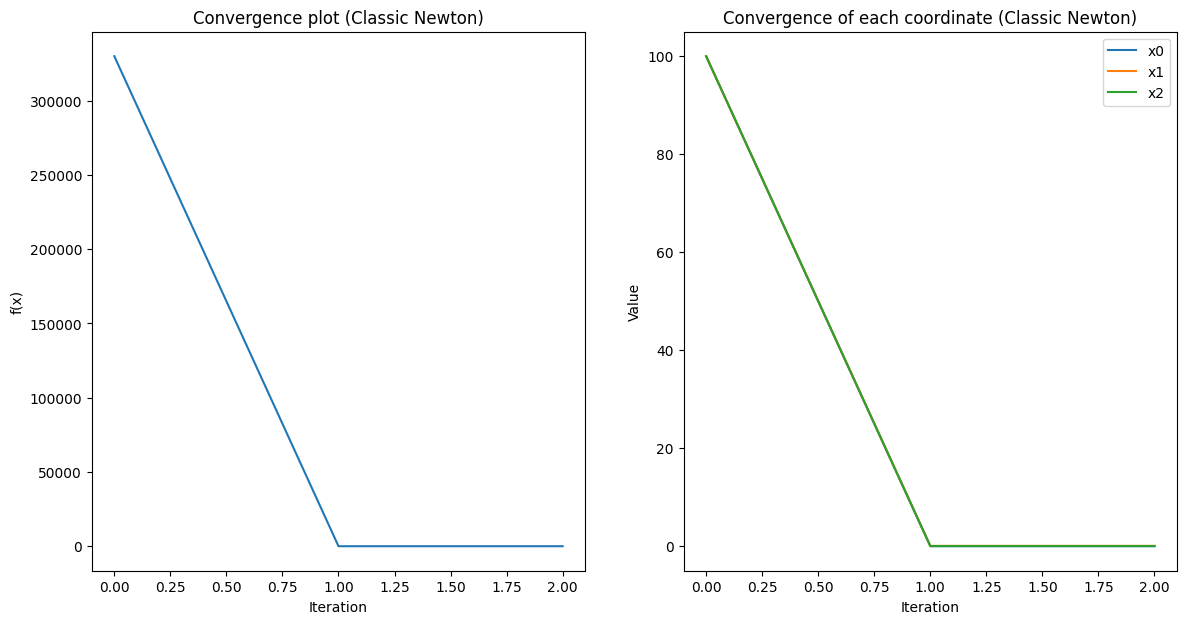

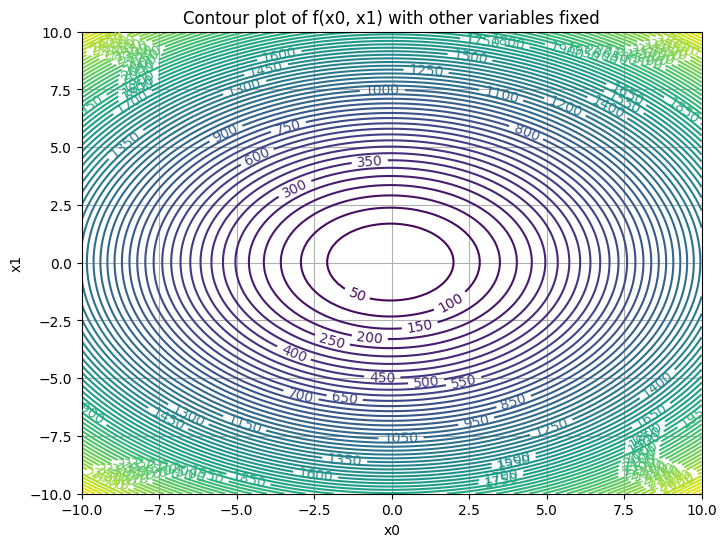

Класичний метод Ньютона:
Градієнт у точці мінімуму: [2.35011409e-17 0.00000000e+00 0.00000000e+00]
Матриця Гессе у точці мінімуму:
[[ 2.4e+01  0.0e+00 -1.0e-02]
 [ 0.0e+00  3.6e+01  0.0e+00]
 [-1.0e-02  0.0e+00  6.0e+00]]
Точка, в якій досягається мінімум: [-4.16666956e-02  2.77777778e-02 -6.94444927e-05]
Значення мінімуму функції: -0.0347222366898249
Regulated Newton - Iteration 1: point = [-4.16666956e-02  2.77777778e-02 -6.94444927e-05], f(point) = -0.0347222366898249
Regulated Newton - Iteration 2: point = [-4.16666956e-02  2.77777778e-02 -6.94444927e-05], f(point) = -0.0347222366898249


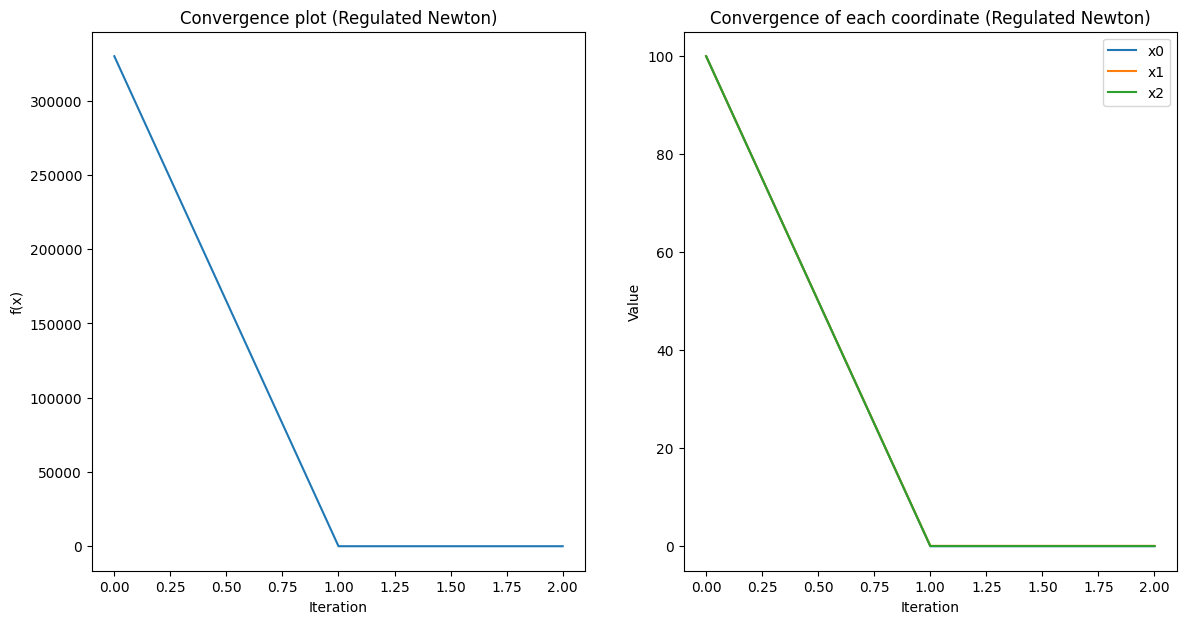

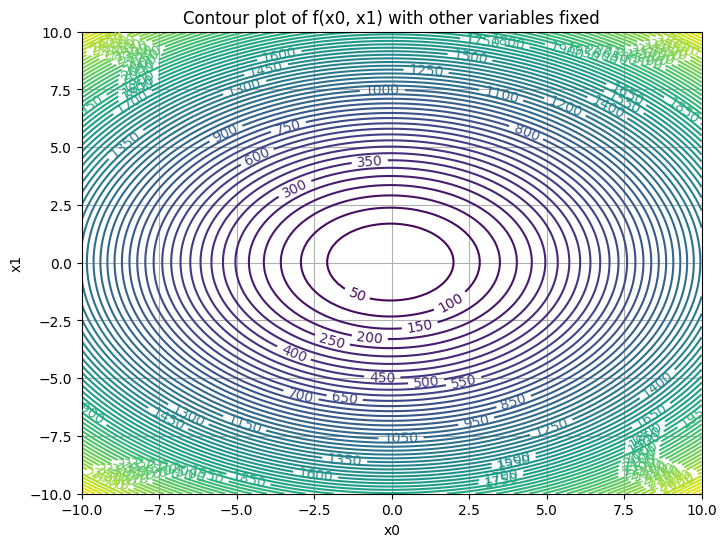

Регульований метод Ньютона:
Градієнт у точці мінімуму: [2.35011409e-17 0.00000000e+00 0.00000000e+00]
Матриця Гессе у точці мінімуму:
[[ 2.4e+01  0.0e+00 -1.0e-02]
 [ 0.0e+00  3.6e+01  0.0e+00]
 [-1.0e-02  0.0e+00  6.0e+00]]
Точка, в якій досягається мінімум: [-4.16666956e-02  2.77777778e-02 -6.94444927e-05]
Значення мінімуму функції: -0.0347222366898249


In [6]:
def func(x, y=0, z=0):
    return 12*x**2 + 18*y**2 +  3*z**2 - 0.01*x*z + x - y


# Виконання прикладу
example_usage(func, 3, [100]*3)

Classic Newton - Iteration 1: point = [  99.99995    9999.99000001], f(point) = 980099.010000750
Classic Newton - Iteration 2: point = [ 1.00004939e+00 -9.79998022e+03], f(point) = 960592152345.042
Classic Newton - Iteration 3: point = [1.00004939 1.00009879], f(point) = 2.43972859333291E-7
Classic Newton - Iteration 4: point = [1. 1.], f(point) = 5.95227584335003E-14
Classic Newton - Iteration 5: point = [1. 1.], f(point) = 1.25737032721243E-26


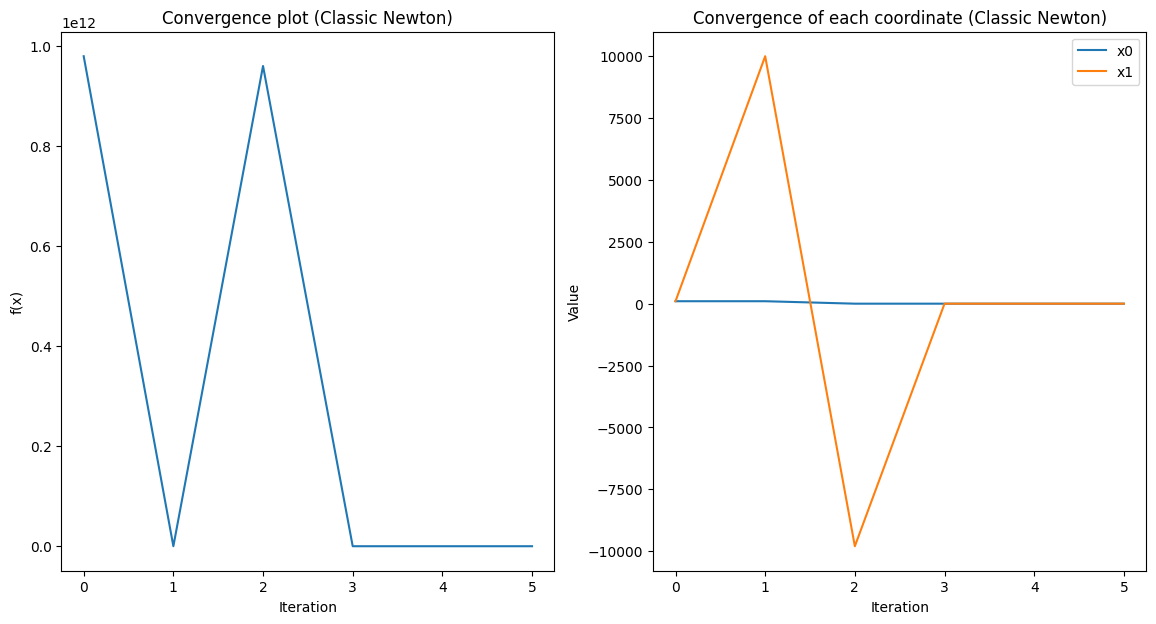

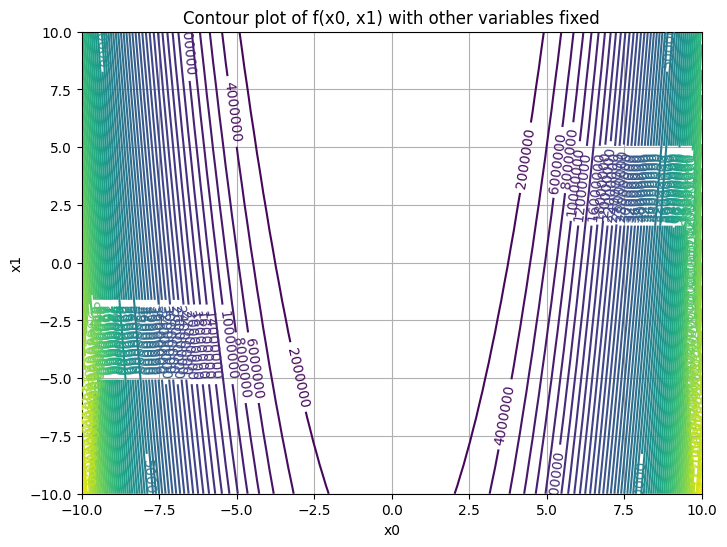

Класичний метод Ньютона:
Градієнт у точці мінімуму: [0. 0.]
Матриця Гессе у точці мінімуму:
[[ 80200. -40000.]
 [-40000.  20000.]]
Точка, в якій досягається мінімум: [1. 1.]
Значення мінімуму функції: 1.25737032721243E-26
Regulated Newton - Iteration 1: point = [  99.99995    9999.99000001], f(point) = 980099.010000750
Regulated Newton - Iteration 2: point = [ 1.00004939e+00 -9.79998022e+03], f(point) = 960592152345.042
Regulated Newton - Iteration 3: point = [ 1.00004939e+00 -4.89949006e+03], f(point) = 240148038086.261
Regulated Newton - Iteration 4: point = [ 1.00004939e+00 -2.44924498e+03], f(point) = 60037009521.5652
Regulated Newton - Iteration 5: point = [ 1.00004939e+00 -1.22412244e+03], f(point) = 15009252380.3913
Regulated Newton - Iteration 6: point = [   1.00004939 -611.56117122], f(point) = 3752313095.09782
Regulated Newton - Iteration 7: point = [   1.00004939 -305.28053621], f(point) = 938078273.774456
Regulated Newton - Iteration 8: point = [   1.00004939 -152.14021871]

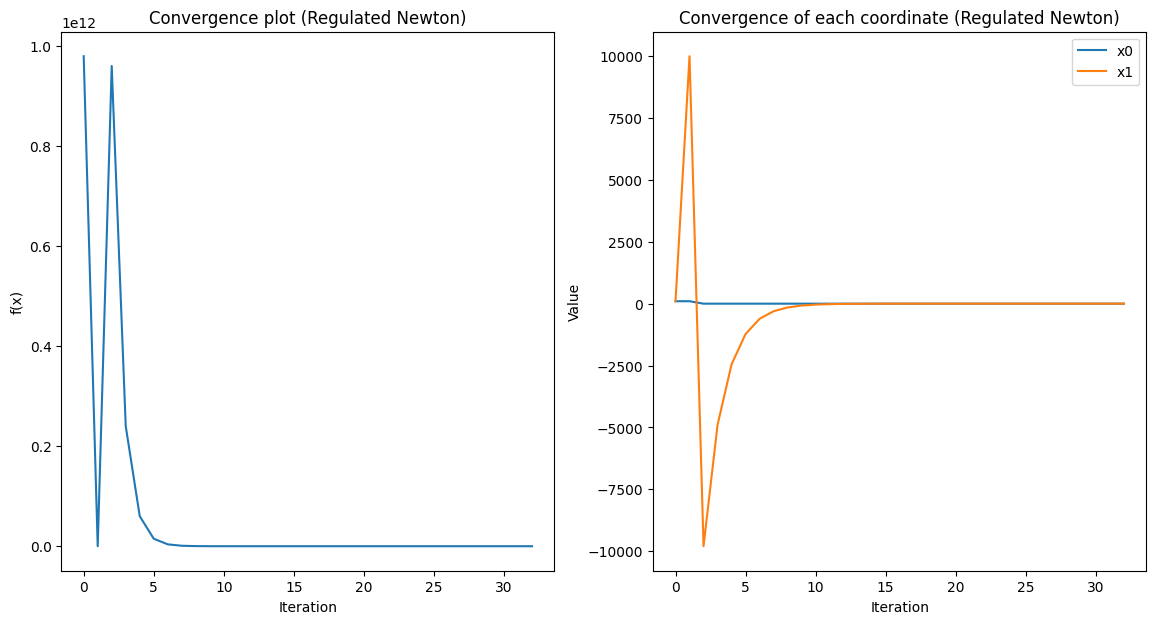

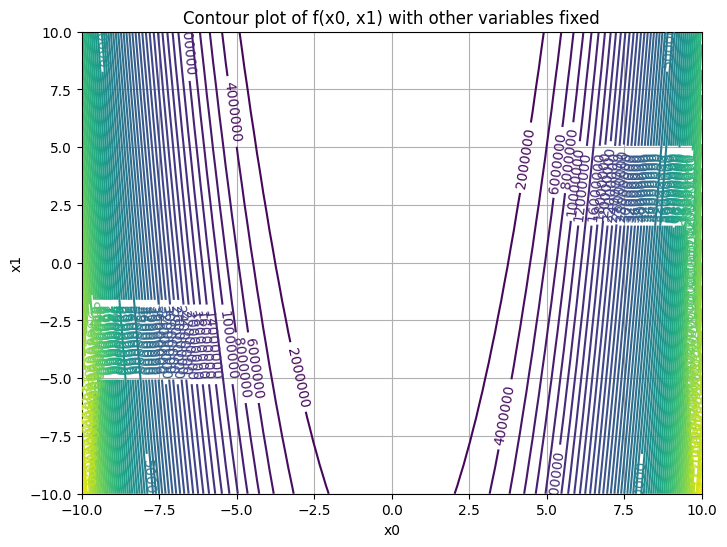

Регульований метод Ньютона:
Градієнт у точці мінімуму: [ 0.36515109 -0.18255754]
Матриця Гессе у точці мінімуму:
[[ 80200.39386509 -40000.0071875 ]
 [-40000.0071875   20000.        ]]
Точка, в якій досягається мінімум: [1.00000018 0.99999123]
Значення мінімуму функції: 8.33184635188416E-7


In [7]:
def test_func(x, y):
    return 10_000*(y - x**2)**2 + 100*(1 - x)**2


example_usage(test_func, 2, [100]*2)